#  Markov chain Monte Carlo algorithm for a Bayesian (single) change point model

#### Ejercicio: Identificar el punto de cambio y estimar las intensidades del proceso de Poisson antes y después del punto de cambio para un serie de datos.

# Chandra Orion star flares

Nuestro Sol y las estrellas ordinarias que vemos en la noche parecen constantes en brillo a nuestros ojos desnudos. Pero en otras longitudes de onda de luz donde las estrellas son mucho más débiles (como la radio, los rayos X y los rayos gamma), las estrellas varían violentamente en escalas de tiempo rápidas. Estas emisiones surgen de liberaciones explosivas de energía en la superficie estelar asociadas con campos magnéticos. Las fuentes de rayos X a veces son muy débiles -solo un puñado de fotones llegan a la observación-. Los tiempos de llegada de estos fotones pueden verse como un proceso de Poisson [1].

Tomado de:https://astrostatistics.psu.edu/datasets/Chandra_flares.html 

El proceso de Poisson es conocido en la estadística como un proceso estocástico que pretende registrar los sucesos muy poco probables en tiempo continuo [2]. 


<img src=https://4.bp.blogspot.com/_UJL3UXvg87Q/R1x4qvNz60I/AAAAAAAAAJI/ntEsFAQDk1k/w1200-h630-p-k-no-nu/poisson3.jpg width="300"/>



In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data= pd.read_csv("COUP551_rates.dat" , skiprows= 1, delim_whitespace=True, error_bad_lines=False )
data.head()

,Tbin,Cts
0,0,11
1,1,3
2,2,5
3,3,9
4,4,3


Los datos sin procesar dan los tiempos de llegada de los fotones individuales (en segundos) y sus energías (en keV). Los datos procesados que consideramos aquí se obtienen agrupando los eventos en intervalos de tiempo espaciados uniformemente (ancho de 10000 segundos).

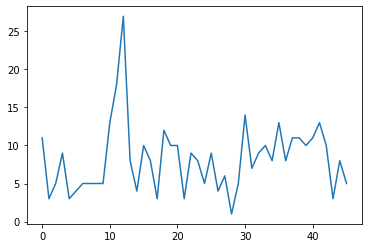

In [3]:
plt.plot(data["Tbin"], data["Cts"])

Nuestro objetivo es simular múltiples extracciones de la distribución posterior, que es una distribución multidimensional. A partir de esta distribución multidimensional, podemos derivar fácilmente la distribución condicional de cada uno de los parámetros individuales (una dimensión a la vez) usando el algoritmo Metropolis-Hastings.

El algoritmo Metropolis-Hastings es un método de Monte Carlo en cadena de Markov para obtener una secuencia de muestras aleatorias a partir de una distribución de probabilidad a partir de la cual es difícil el muestreo directo. 

In [4]:
k_estimado= 10
def sampler(it=1000, data=data):
    data['Tbin'] = data['Tbin'].astype(float)
    data['Cts'] = data['Cts'].astype(float)
    n=len(data)
    ## each row corresponds to one of 5 parameters in order: theta,lambda,k,b1,b2
    ## each column corresponds to a single state of the Markov chain
    cadenam= np.zeros((5,it))
    acc= 0 
    k_inic = np.floor(n/2) 
    ## starting values for Markov chain
    ## This is somewhat arbitrary but any method that produces reasonable values for each parameter is usually adequate.

    cadenam[:,0] = np.array([1,1,k_inic,1,1])
    
    for i in range(1, it): 
        
        currtheta = cadenam[0,i-1]
        currlambda = cadenam[1,i-1]
        currk = cadenam[2,i-1]
        currb1 = cadenam[3,i-1]
        currb2 = cadenam[4,i-1]
        
        ## sample from full conditional distribution of theta (Gibbs update)
        currtheta = np.random.gamma(shape=np.sum(data["Cts"][1:int(currk)])+0.5, scale=currb1/(currk*currb1+1), size=1)
        
        ## sample from full conditional distribution of lambda (Gibbs update)
        currlambda = np.random.gamma(shape=np.sum(data["Cts"][int((currk+1)):n])+0.5, scale=currb2/((n-currk)*currb2+1), size=1)
        
        ## sample from full conditional distribution of k (Metropolis-Hastings update)
        x = np.arange(2,n)
        propk = np.random.choice(x, size=1) # draw one sample at random from uniform{2,..(n-1)}

        ## Metropolis accept-reject step (in log scale)
        logMHratio = np.sum(data["Cts"][0:int(propk)])*np.log(currtheta)+np.sum(data["Cts"][int((propk+1)):n])*np.log(currlambda)-propk*currtheta- (n-propk)*currlambda - (np.sum(data["Cts"][0:int(currk)])*np.log(currtheta)+np.sum(data["Cts"][int((currk+1)):n])*np.log(currlambda)-currk*currtheta- (n-currk)*currlambda)
        logalpha = min(0,logMHratio) # alpha = min(1,MHratio)
        x1= np.log(np.random.uniform(size=1))
        if  x1 < logalpha : # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
            acc = acc + 1 # increment count of accepted proposals
            currk = propk
        
        currk = k_estimado # if we do not sample k (k fixed)
        
        ## sample from full conditional distribution of b1 (Gibbs update): draw from Inverse Gamma
        currb1 = 1/np.random.gamma(shape=0.5, scale=1/(currtheta+1), size=1)
        
        ## sample from full conditional distribution of b2 (Gibbs update): draw from Inverse Gamma
        currb2 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda+1), size=1)
        
        ## update chain with new values
        cadenam[:,i] = np.array([currtheta,currlambda,currk,currb1,currb2])
        
    print("Markov chain algorithm ran for ",it,"iterations (acc.rate for k=",acc/(it-1),")\n")
    print("Parameters are in order: theta, lambda, k, b1, b2\n")
    return(cadenam)

In [5]:
cadenam= sampler(1000,data)
cadenam

Markov chain algorithm ran for  1000 iterations (acc.rate for k= 0.22622622622622623 )

Parameters are in order: theta, lambda, k, b1, b2



array([[1.00000000e+00, 7.47587489e+00, 4.07949251e+00, ...,
        4.63776933e+00, 4.40095090e+00, 4.89897639e+00],
       [1.00000000e+00, 7.33379757e+00, 8.71055470e+00, ...,
        8.57766443e+00, 7.88740813e+00, 8.21871538e+00],
       [2.30000000e+01, 1.00000000e+01, 1.00000000e+01, ...,
        1.00000000e+01, 1.00000000e+01, 1.00000000e+01],
       [1.00000000e+00, 6.32121271e+03, 1.13024011e+01, ...,
        2.10511358e+03, 2.33974054e+00, 4.55382751e+00],
       [1.00000000e+00, 9.16713464e+02, 1.47767294e+01, ...,
        1.97222248e+01, 3.06679289e+01, 2.03718626e+02]])

In [6]:
np.mean(cadenam[0,:])

4.41799945851334

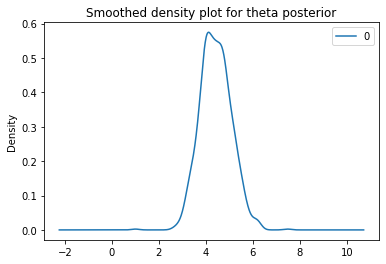

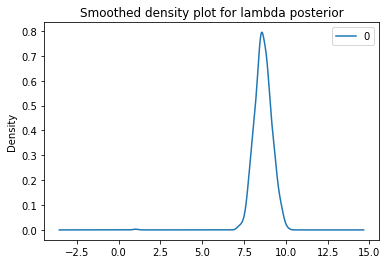

In [7]:
pd.DataFrame(cadenam[0,:]).plot(kind='density', title= "Smoothed density plot for theta posterior")
pd.DataFrame(cadenam[1,:]).plot(kind="density", title= "Smoothed density plot for lambda posterior")

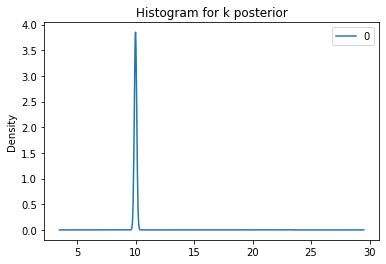

In [8]:
pd.DataFrame(cadenam[2,:]).plot(kind="density", title= "Histogram for k posterior")

#### Para encontrar la probabilidad (posterior) de que lambda sea mayor que 10:

In [9]:
np.sum(cadenam[1,:]>10)/len(cadenam[1,:])

0.002

## Bibliografía:
[1] Penn State University. (2010). Chandra Orion star flares. Eberly College of Science. 
https://astrostatistics.psu.edu/datasets/Chandra_flares.html

[2] Introduction to Probability by Hossein Pishro-Nik. (n.d.). Basic Concepts of the Poisson Process. Introduction to Probability. https://www.probabilitycourse.com/chapter11/11_1_2_basic_concepts_of_the_poisson_process.php

[3] Haran, M. (n.d.). A Markov chain Monte Carlo example. Astrostat. http://www.iiap.res.in/astrostat/School07/R/MCMC.html